# Data Analysis

### Import Data

In [1]:
import pandas as pd

## IMPORT DATA

## First with temp off
data_current_feb20_trial07_full = pd.read_csv('./data/cleaned_data/02-20-2023/anode_current/Physics 405 - Exp 3 - Trail 07.csv', sep=",", engine='python', names=["time", "potentail 2", "current"])
data_current_feb20_trial07_narrow = data_current_feb20_trial07_full[10:]
data_current_feb20_trial07_narrow = data_current_feb20_trial07_narrow.astype(float)

data_current_feb20_trial08_full = pd.read_csv('./data/cleaned_data/02-20-2023/anode_current/Physics 405 - Exp 3 - Trail 08.csv', sep=",", engine='python', names=["time", "potentail 2", "current"])
data_current_feb20_trial08_narrow = data_current_feb20_trial08_full[10:]
data_current_feb20_trial08_narrow = data_current_feb20_trial08_narrow.astype(float)

## Everything off
data_ramping_feb20_trial03_full = pd.read_csv('./data/cleaned_data/02-20-2023/ramping_voltage/Physics 405 - Exp 3 - Trail 03.csv', sep=",", engine='python', names=["time", "ramping", "current"])
data_ramping_feb20_trial03_narrow = data_ramping_feb20_trial03_full[10:]
# print(data_current_feb20_trial01_narrow)
data_ramping_feb20_trial03_narrow = data_ramping_feb20_trial03_narrow.astype(float)
data_ramping_feb20_trial03_narrow['ramping'] = data_ramping_feb20_trial03_narrow['ramping'] * 10

data_ramping_feb20_trial04_full = pd.read_csv('./data/cleaned_data/02-20-2023/ramping_voltage/Physics 405 - Exp 3 - Trail 04.csv', sep=",", engine='python', names=["time", "ramping", "current"])
data_ramping_feb20_trial04_narrow = data_ramping_feb20_trial04_full[10:]
# print(data_current_feb20_trial01_narrow)
data_ramping_feb20_trial04_narrow = data_ramping_feb20_trial04_narrow.astype(float)
data_ramping_feb20_trial04_narrow['ramping'] = data_ramping_feb20_trial04_narrow['ramping'] * 10


### Calculate Initial Uncertainties

In [3]:
import numpy as np

experiment_three_object = {
    "ramping_uncert": np.average([np.std(data_current_feb20_trial07_narrow['potentail 2'] * 10),np.std(data_current_feb20_trial08_narrow['potentail 2'] * 10)]),
    "current_uncert": np.average([np.std(data_ramping_feb20_trial03_narrow['current']),np.std(data_ramping_feb20_trial04_narrow['current'])])
}


print(f"Ramping Uncert: {experiment_three_object['ramping_uncert']}")
print(f"Current Uncert: {experiment_three_object['current_uncert']}")

Ramping Uncert: 0.021427431345337148
Current Uncert: 0.38706957560019006


### Format data frames and calculate mins to get background fit

In [37]:
from scipy.optimize import curve_fit
import scipy.stats as st  

trail_07_04_fit = pd.DataFrame()
trail_07_04_fit['current'] = data_current_feb20_trial07_narrow['current']
trail_07_04_fit['accelerating'] = data_ramping_feb20_trial04_narrow['ramping']

x_lines = [09.5,10.5,13,15,17.5,20,23,24.3,28,29.2,33.2,34.2,38.2,39.2]

min_1 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[2]) & (trail_07_04_fit['accelerating']<x_lines[3])]
min_2 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[4]) & (trail_07_04_fit['accelerating']<x_lines[5])]
min_3 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[6]) & (trail_07_04_fit['accelerating']<x_lines[7])]
min_4 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[8]) & (trail_07_04_fit['accelerating']<x_lines[9])]
min_5 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[10]) & (trail_07_04_fit['accelerating']<x_lines[11])]
min_6 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating']>x_lines[12]) & (trail_07_04_fit['accelerating']<x_lines[13])]

def calculate_min(data):
    min = data['current'].min()
    closest_min = data.loc[data['current'] == min]
    closest_min_avg = np.average(closest_min['accelerating'])
    return (float(min),float(closest_min_avg))

def objective(x, a, b, c):
    return a * x + b * x**2 + c

minimums = pd.DataFrame()

min_1_y,min_1_x = calculate_min(data=min_1)
min_2_y,min_2_x = calculate_min(data=min_2)
min_3_y,min_3_x = calculate_min(data=min_3)
min_4_y,min_4_x = calculate_min(data=min_4)
min_5_y,min_5_x = calculate_min(data=min_5)
min_6_y,min_6_x = calculate_min(data=min_6)

minimums_x = [min_1_x,min_2_x,min_3_x,min_4_x,min_5_x,min_6_x]
minimums_y = [min_1_y,min_2_y,min_3_y,min_4_y,min_5_y,min_6_y]
minimums['x'] = minimums_x
minimums['y'] = minimums_y

param, param_cov = curve_fit(objective, minimums['x'], minimums['y'])
fit = objective(minimums['x'], param[0], param[1], param[2])


experiment_three_object['background'] = {
    'best_fit_a': param[0],
    'best_fit_b': param[1],
    'best_fit_c': param[2]
}



print(f"BG Fit A: {experiment_three_object['background']['best_fit_a']}")
print(f"BG Fit B: {experiment_three_object['background']['best_fit_b']}")
print(f"BG Fit C: {experiment_three_object['background']['best_fit_c']}")

def chi_squared(Theory,Data,sigma):
    if np.size(Theory)==np.size(Data):
        chi2=np.sum((Theory-Data)**2/sigma**2)
        return chi2
    else:
        print('error - arrays of unequal size')
        return -1.

background_sigma = 38 
chi2 = chi_squared(fit, minimums['y'],sigma=background_sigma)
dof = len(minimums_x) - 3

experiment_three_object['background'] = {
    'best_fit_a': param[0],
    'best_fit_b': param[1],
    'best_fit_c': param[2],
    'best_fit_chi2': chi2,
    'best_fit_dof': dof,
    'best_fit_prob': st.chi2.sf(chi2,dof),
    'best_fit_sigma': background_sigma
}

## Uncomment to plot

# plt.errorbar(minimums_x,minimums_y, fmt='.', yerr=38)
# plt.plot(minimums_x, fit, '-', label='Best fit line')
# plt.show()

BG Fit A: -27.108849309974836
BG Fit B: 0.7089981634648568
BG Fit C: 255.971103819725


### Begin fitting individual gaussians

In [38]:
# Selected as fit does not work for lower currents
best_fit_data = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_1_x)]

guass_1 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_1_x) & (trail_07_04_fit['accelerating'] <= min_2_x)]
guass_2 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_2_x) & (trail_07_04_fit['accelerating'] <= min_3_x)]
guass_3 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_3_x) & (trail_07_04_fit['accelerating'] <= min_4_x)]
guass_4 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_4_x) & (trail_07_04_fit['accelerating'] <= min_5_x)]
guass_5 = trail_07_04_fit.loc[(trail_07_04_fit['accelerating'] >= min_5_x) & (trail_07_04_fit['accelerating'] <= min_6_x)]

# plt.plot(guass_1['accelerating'],guass_1['current'],'.',color='blue')
# plt.plot(guass_2['accelerating'],guass_2['current'],'.',color='red')
# plt.plot(guass_3['accelerating'],guass_3['current'],'.',color='green')
# plt.plot(guass_4['accelerating'],guass_4['current'],'.',color='orange')
# plt.plot(guass_5['accelerating'],guass_5['current'],'.',color='purple')


def model(x,gauss_a,x0,sigma):
    bg_a = experiment_three_object['background']['best_fit_a']
    bg_b = experiment_three_object['background']['best_fit_b']
    bg_c = experiment_three_object['background']['best_fit_c']
    gaussian = gauss_a*np.exp(-(x-x0)**2/(2*sigma**2))
    bg = bg_a * x + bg_b * x**2 + bg_c
    return gaussian + bg

param_gauss_1, param_cov_gauss_1 = curve_fit(model, guass_1['accelerating'], guass_1['current'], p0=[10,56,16.8])
fit_gauss_1 = model(guass_1['accelerating'], param_gauss_1[0], param_gauss_1[1], param_gauss_1[2])
experiment_three_object['gauss_1'] = {
    'a': param[0],
    'x0': param[1],
    'sigma': param[2]
}
# print(param_gauss_1[0], param_gauss_1[1], param_gauss_1[2])

param_gauss_2, param_cov_gauss_2 = curve_fit(model, guass_2['accelerating'], guass_2['current'], p0=[500,21.7,21.7])
fit_gauss_2 = model(guass_2['accelerating'], param_gauss_2[0], param_gauss_2[1], param_gauss_2[2])
experiment_three_object['gauss_2'] = {
    'a': param[0],
    'x0': param[1],
    'sigma': param[2]
}
# print(param_gauss_2[0], param_gauss_2[1], param_gauss_2[2])

param_gauss_3, param_cov_gauss_3 = curve_fit(model, guass_3['accelerating'], guass_3['current'], p0=[500,35,26.3])
fit_gauss_3 = model(guass_3['accelerating'], param_gauss_3[0], param_gauss_3[1], param_gauss_3[2])
experiment_three_object['gauss_3'] = {
    'a': param[0],
    'x0': param[1],
    'sigma': param[2]
}
# print(param_gauss_3[0], param_gauss_3[1], param_gauss_3[2])

param_gauss_4, param_cov_gauss_4 = curve_fit(model, guass_4['accelerating'], guass_4['current'],p0=[350,5,32])
fit_gauss_4 = model(guass_4['accelerating'], param_gauss_4[0], param_gauss_4[1], param_gauss_4[2])
experiment_three_object['gauss_4'] = {
    'a': param[0],
    'x0': param[1],
    'sigma': param[2]
}
# print(param_gauss_4[0], param_gauss_4[1], param_gauss_4[2])

param_gauss_5, param_cov_gauss_5 = curve_fit(model, guass_5['accelerating'], guass_5['current'],p0=[350,5,32])
fit_gauss_5 = model(guass_5['accelerating'], param_gauss_5[0], param_gauss_5[1], param_gauss_5[2])
experiment_three_object['gauss_5'] = {
    'a': param[0],
    'x0': param[1],
    'sigma': param[2]
}
# print(param_gauss_5[0], param_gauss_5[1], param_gauss_5[2])

# plt.plot(guass_1['accelerating'],guass_1['current'],'.',color='blue')
# plt.plot(guass_1['accelerating'],fit_gauss_1,'-',color='blue')

# plt.plot(guass_2['accelerating'],guass_2['current'],'.',color='red')
# plt.plot(guass_2['accelerating'],fit_gauss_2,'-',color='red')

# plt.plot(guass_3['accelerating'],guass_3['current'],'.',color='green')
# plt.plot(guass_3['accelerating'],fit_gauss_3,'-',color='green')

# plt.plot(guass_4['accelerating'],guass_4['current'],'.',color='orange')
# plt.plot(guass_4['accelerating'],fit_gauss_4,'-',color='orange')

# plt.plot(guass_5['accelerating'],guass_5['current'],'.',color='purple')
# plt.plot(guass_5['accelerating'],fit_gauss_5,'-',color='purple')

# plt.show()



### Do full model fit

In [50]:
best_fit_initial_params = {
    "bg_a": experiment_three_object['background']['best_fit_a'],
    "bg_b": experiment_three_object['background']['best_fit_b'],
    "bg_c": experiment_three_object['background']['best_fit_c'],
    "param_gauss_1_a":param_gauss_1[0],
    "param_gauss_1_x0":param_gauss_1[1],
    "param_gauss_1_sigma":param_gauss_1[2],
    "param_gauss_2_a":param_gauss_2[0],
    "param_gauss_2_x0":param_gauss_2[1],
    "param_gauss_2_sigma":param_gauss_2[2],
    "param_gauss_3_a":param_gauss_3[0],
    "param_gauss_3_x0":param_gauss_3[1],
    "param_gauss_3_sigma":param_gauss_3[2],
    "param_gauss_4_a":param_gauss_4[0],
    "param_gauss_4_x0":param_gauss_4[1],
    "param_gauss_4_sigma":param_gauss_4[2],
    "param_gauss_5_a":param_gauss_5[0],
    "param_gauss_5_x0":param_gauss_5[1],
    "param_gauss_5_sigma":param_gauss_5[2]
} 

def franck_hertz_model(
        x,
        bg_a,
        bg_b,
        bg_c,
        param_gauss_1_a,
        param_gauss_1_x0,
        param_gauss_1_sigma,
        param_gauss_2_a,
        param_gauss_2_x0,
        param_gauss_2_sigma,
        param_gauss_3_a,
        param_gauss_3_x0,
        param_gauss_3_sigma,
        param_gauss_4_a,
        param_gauss_4_x0,
        param_gauss_4_sigma,
        param_gauss_5_a,
        param_gauss_5_x0,
        param_gauss_5_sigma
):
    gaussian_1 = param_gauss_1_a*np.exp(-(x-param_gauss_1_x0)**2/(2*param_gauss_1_sigma**2))
    gaussian_2 = param_gauss_2_a*np.exp(-(x-param_gauss_2_x0)**2/(2*param_gauss_2_sigma**2))
    gaussian_3 = param_gauss_3_a*np.exp(-(x-param_gauss_3_x0)**2/(2*param_gauss_3_sigma**2))
    gaussian_4 = param_gauss_4_a*np.exp(-(x-param_gauss_4_x0)**2/(2*param_gauss_4_sigma**2))
    gaussian_5 = param_gauss_5_a*np.exp(-(x-param_gauss_5_x0)**2/(2*param_gauss_5_sigma**2))
    bg = bg_a * x + bg_b * x**2 + bg_c
    return gaussian_1 + gaussian_2 + gaussian_3 + gaussian_4 + gaussian_5 + bg

best_param, best_param_cov = curve_fit(franck_hertz_model, best_fit_data['accelerating'], best_fit_data['current'],p0=[
    best_fit_initial_params['bg_a'],
    best_fit_initial_params['bg_b'],
    best_fit_initial_params['bg_c'],
    best_fit_initial_params['param_gauss_1_a'],
    best_fit_initial_params['param_gauss_1_x0'],
    best_fit_initial_params['param_gauss_1_sigma'],
    best_fit_initial_params['param_gauss_2_a'],
    best_fit_initial_params['param_gauss_2_x0'],
    best_fit_initial_params['param_gauss_2_sigma'],
    best_fit_initial_params['param_gauss_3_a'],
    best_fit_initial_params['param_gauss_3_x0'],
    best_fit_initial_params['param_gauss_3_sigma'],
    best_fit_initial_params['param_gauss_4_a'],
    best_fit_initial_params['param_gauss_4_x0'],
    best_fit_initial_params['param_gauss_4_sigma'],
    best_fit_initial_params['param_gauss_5_a'],
    best_fit_initial_params['param_gauss_5_x0'],
    best_fit_initial_params['param_gauss_5_sigma']
    ],maxfev=50000)

best_fit = franck_hertz_model(best_fit_data['accelerating'], best_param[0], best_param[1], best_param[2], best_param[3], best_param[4], best_param[5], best_param[6], best_param[7], best_param[8], best_param[9], best_param[10], best_param[11], best_param[12], best_param[13], best_param[14], best_param[15], best_param[16], best_param[17])

model_sigma = 13
chi2 = chi_squared(best_fit, best_fit_data['current'],sigma=model_sigma)
dof = len(best_fit) - 18
prob = st.chi2.sf(chi2,dof)

experiment_three_object['model'] = {
    'best_fit_chi2': chi2,
    'best_fit_dof': dof,
    'best_fit_prob': st.chi2.sf(chi2,dof),
    'best_fit_sigma': model_sigma
}

# plt.text(20,600,r'$\chi_\nu^2$ = {:.2f}'.format(chi2/dof))
# plt.text(20,550,r'prob = {:.2f}'.format(prob))


### Calculate max of fit

In [57]:
best_fit_df = pd.DataFrame()
best_fit_df['accelerating'] = best_fit_data['accelerating']
best_fit_df['current'] = best_fit

x_fits = []
x_fits.append(15)
x_fits.append(17.5)

x_fits.append(20)
x_fits.append(24)

x_fits.append(25)
x_fits.append(28.5)

x_fits.append(30)
x_fits.append(32.5)

x_fits.append(35)
x_fits.append(37.5)

def calculate_max(data):
    max = data['current'].max()
    closest_max = data.loc[data['current'] == max]
    closest_max_avg = np.average(closest_max['accelerating'])
    return (max,closest_max_avg)

max_1 = best_fit_df.loc[(best_fit_df['accelerating']>x_fits[0]) & (best_fit_df['accelerating']<x_fits[1])]
max_2 = best_fit_df.loc[(best_fit_df['accelerating']>x_fits[2]) & (best_fit_df['accelerating']<x_fits[3])]
max_3 = best_fit_df.loc[(best_fit_df['accelerating']>x_fits[4]) & (best_fit_df['accelerating']<x_fits[5])]
max_4 = best_fit_df.loc[(best_fit_df['accelerating']>x_fits[6]) & (best_fit_df['accelerating']<x_fits[7])]
max_5 = best_fit_df.loc[(best_fit_df['accelerating']>x_fits[8]) & (best_fit_df['accelerating']<x_fits[9])]

maximums = pd.DataFrame()

max_1_y,max_1_x = calculate_max(data=max_1)

max_2_y,max_2_x = calculate_max(data=max_2)

max_3_y,max_3_x = calculate_max(data=max_3)
max_4_y,max_4_x = calculate_max(data=max_4)
max_5_y,max_5_x = calculate_max(data=max_5)

maximums_x = [max_1_x,max_2_x,max_3_x,max_4_x,max_5_x]
maximums_y = [max_1_y,max_2_y,max_3_y,max_4_y,max_5_y]
maximums['x'] = maximums_x
maximums['y'] = maximums_y

maximum_energies = maximums['x'].to_numpy()


delta_1 = maximum_energies[1] - maximum_energies[0]
delta_2 = maximum_energies[2] - maximum_energies[1]
delta_3 = maximum_energies[3] - maximum_energies[2]
delta_4 = maximum_energies[4] - maximum_energies[3]


final_deltas = [delta_1,delta_2,delta_3,delta_4]
final_delta_E = np.average(final_deltas)
final_delta_E_sigma = np.std(final_deltas)


### Plot everything

Text(15, 350, '$\\sigma_E$ = 0.13')

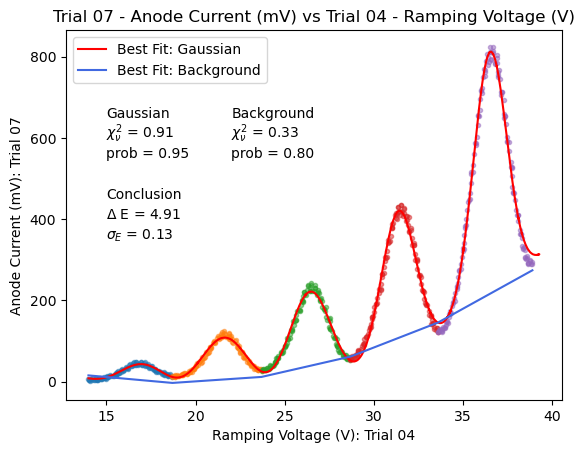

In [63]:
plt.plot(guass_1['accelerating'],guass_1['current'],'.', alpha=0.5)
plt.plot(guass_2['accelerating'],guass_2['current'],'.', alpha=0.5)
plt.plot(guass_3['accelerating'],guass_3['current'],'.', alpha=0.5)
plt.plot(guass_4['accelerating'],guass_4['current'],'.', alpha=0.5)
plt.plot(guass_5['accelerating'],guass_5['current'],'.', alpha=0.5)
plt.errorbar(best_fit_data['accelerating'],best_fit,fmt='-', label='Best Fit: Gaussian',color='red')
plt.errorbar(minimums_x, fit, fmt='-', label='Best Fit: Background', color='royalblue')
# plt.plot(maximums['x'], maximums['y'], '-', label='')
plt.legend()
plt.xlabel('Ramping Voltage (V): Trial 04')
plt.ylabel('Anode Current (mV): Trial 07')
plt.title('Trial 07 - Anode Current (mV) vs Trial 04 - Ramping Voltage (V)')

plt.text(15,650,r'Gaussian')
plt.text(15,600,r'$\chi_\nu^2$ = {:.2f}'.format(chi2/dof))
plt.text(15,550,r'prob = {:.2f}'.format(prob))
# plt.text(15,500,r'$\sigma$ = {:.2f} mV'.format(model_sigma))

plt.text(22,650,r'Background')
plt.text(22,600,r'$\chi_\nu^2$ = {:.2f}'.format(experiment_three_object['background']['best_fit_chi2']/experiment_three_object['background']['best_fit_dof']))
plt.text(22,550,r'prob = {:.2f}'.format(experiment_three_object['background']['best_fit_prob']))

plt.text(15,450,r'Conclusion')
plt.text(15,400,r'$\Delta$ E = {:.2f}'.format(final_delta_E))
plt.text(15,350,r'$\sigma_E$ = {:.2f}'.format(final_delta_E_sigma))
# plt.text(22,500,r'$\sigma$ = {:.2f} mV'.format(experiment_three_object['background']['best_fit_sigma']))